In [1]:
!pip install -q transformers==4.46.0 accelerate sentencepiece
!pip install -q pillow

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 69.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.7 MB/s eta 0:00:00:00:01


2025-12-17 16:22:35.669166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765988555.854174      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765988555.910238      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765988556.345470      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765988556.345513      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765988556.345516      55 computation_placer.cc:177] computation placer alr

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = TrOCRProcessor.from_pretrained(
    "cyrillic-trocr/trocr-handwritten-cyrillic"
)  # [file:1]
model = VisionEncoderDecoderModel.from_pretrained(
    "cyrillic-trocr/trocr-handwritten-cyrillic"
).to(device)  # [file:1]


preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

In [6]:
import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    print(dirname, "->", len(filenames), "files")
    for f in filenames[:5]:
        print("   ", f)

image_dir = "/kaggle/input/cyrillic-handwriting-dataset/test"  # paste the real path here

image_paths = [
    os.path.join(image_dir, f)
    for f in sorted(os.listdir(image_dir))
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
][:5]

image_paths



/kaggle/input -> 0 files
/kaggle/input/cyrillic-handwriting-dataset -> 2 files
    test.tsv
    train.tsv
/kaggle/input/cyrillic-handwriting-dataset/test -> 1544 files
    test1489.png
    test72.png
    test338.png
    test408.png
    test1289.png
/kaggle/input/cyrillic-handwriting-dataset/train -> 72286 files
    yob4628.png
    dem18278.png
    ag3119.png
    dem4597.png
    yob7159.png


['/kaggle/input/cyrillic-handwriting-dataset/test/test0.png',
 '/kaggle/input/cyrillic-handwriting-dataset/test/test1.png',
 '/kaggle/input/cyrillic-handwriting-dataset/test/test10.png',
 '/kaggle/input/cyrillic-handwriting-dataset/test/test100.png',
 '/kaggle/input/cyrillic-handwriting-dataset/test/test1000.png']

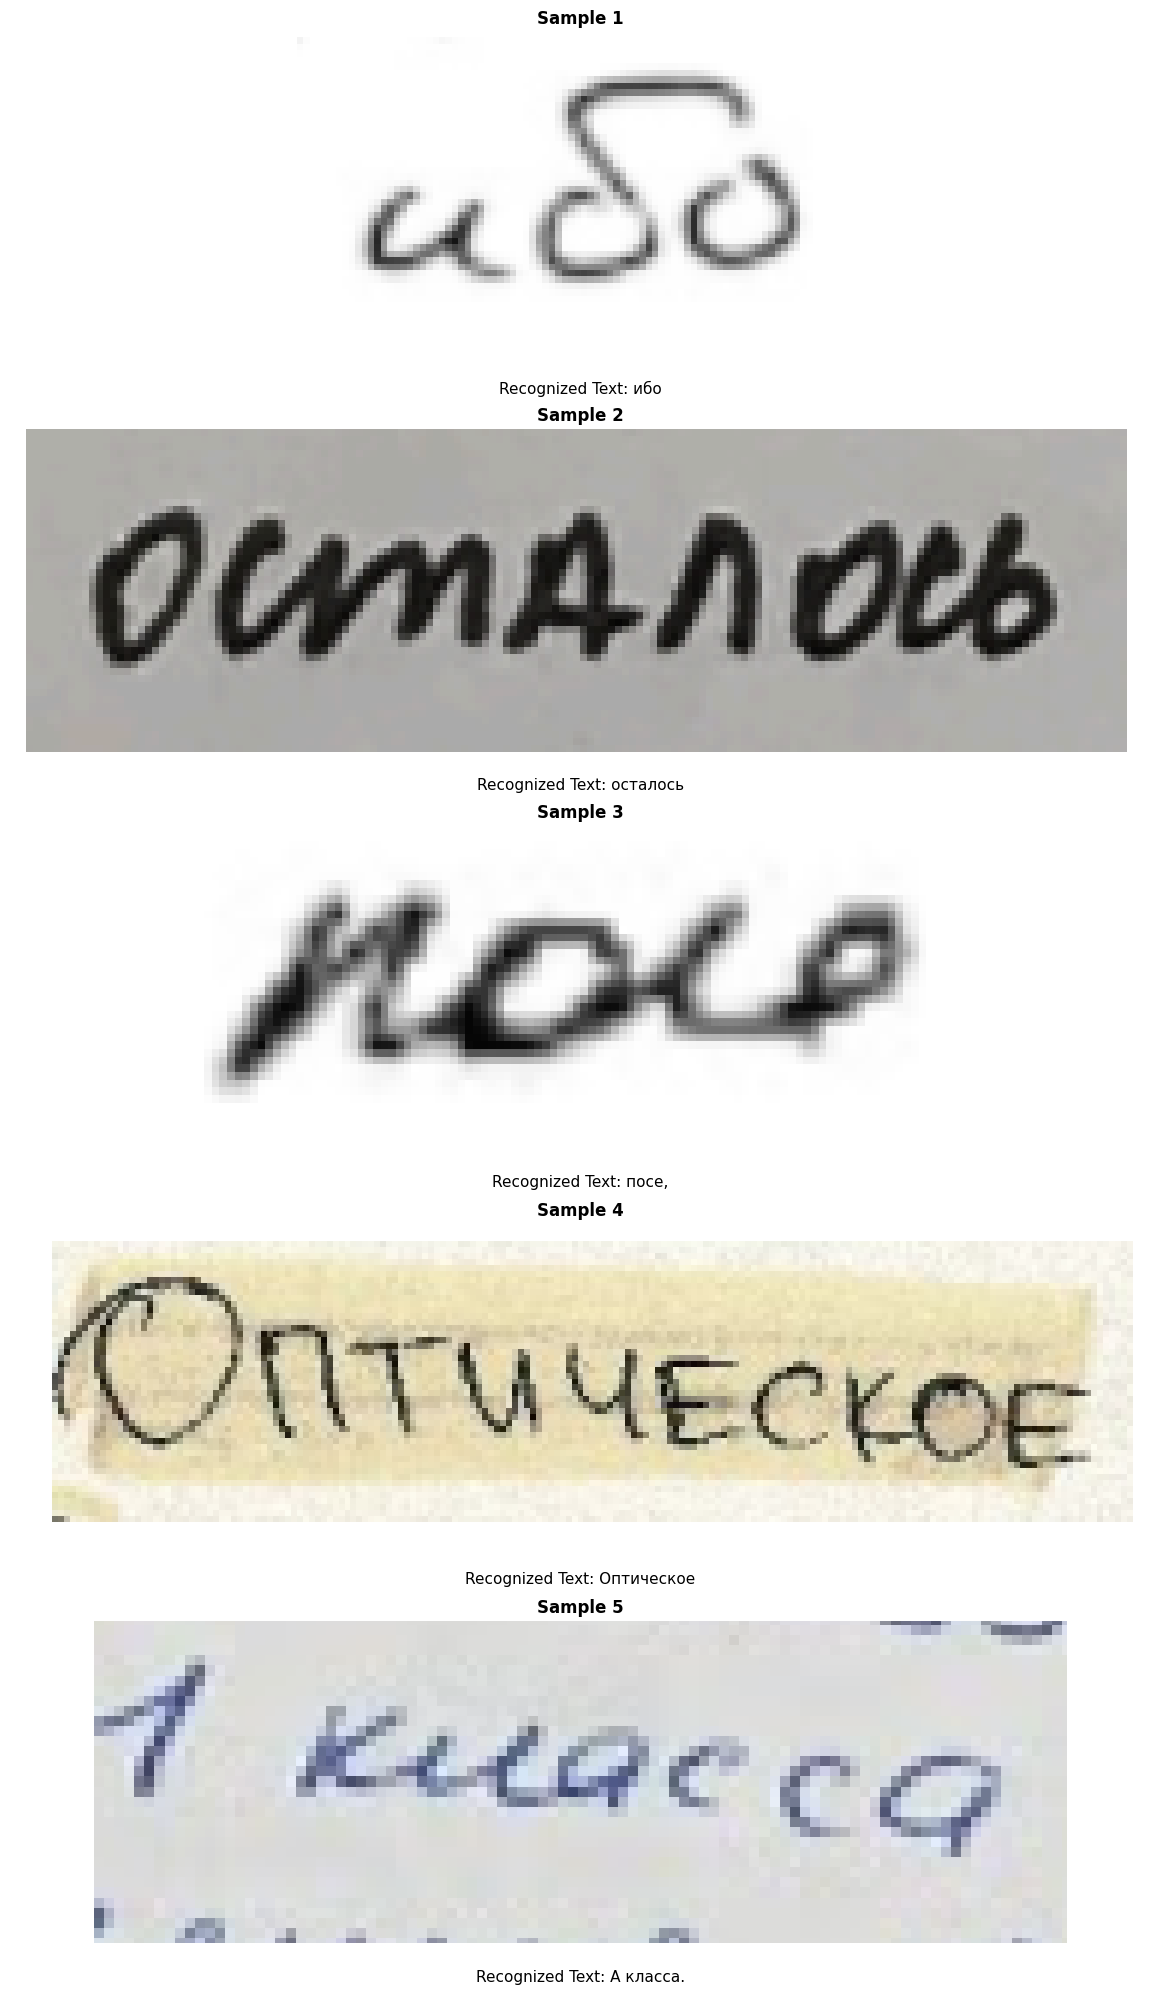


Sample Results:
Sample 1: ибо
Sample 2: осталось
Sample 3: посе,


In [16]:
# Run inference on sample images and display image-text pairs
import matplotlib.pyplot as plt
from PIL import Image

model.eval()

results = []
for img_path in image_paths:
    image = Image.open(img_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=128, num_beams=4)
    pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Store image and text instead of filename
    results.append((image, pred_text))

# Display images with their recognized text
fig, axes = plt.subplots(len(results), 1, figsize=(12, 4*len(results)))

for idx, (img, pred_text) in enumerate(results):
    axes[idx].imshow(img)
    axes[idx].set_title(f"Sample {idx+1}", fontsize=12, fontweight='bold')
    axes[idx].text(0.5, -0.08, f"Recognized Text: {pred_text}", 
                   transform=axes[idx].transAxes, fontsize=11, 
                   verticalalignment='top', horizontalalignment='center')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nSample Results:")
for i, (img, pred_text) in enumerate(results[:3]):
    print(f"Sample {i+1}: {pred_text}")

In [8]:
# Full evaluation on test set
import pandas as pd
from difflib import SequenceMatcher
import numpy as np

# Load ground truth labels from TSV
test_labels_df = pd.read_csv("/kaggle/input/cyrillic-handwriting-dataset/test.tsv", sep='	', header=None)
test_labels_df.columns = ['filename', 'text']
test_labels_dict = dict(zip(test_labels_df['filename'], test_labels_df['text']))

print(f"Loaded {len(test_labels_dict)} ground truth labels")
print(f"Sample labels:")
for i, (k, v) in enumerate(list(test_labels_dict.items())[:3]):
    print(f"  {k}: {v}")

Loaded 1544 ground truth labels
Sample labels:
  test0.png: ибо
  test1.png: осталось
  test10.png: поле


In [9]:
# Run inference on all test images
print("Running inference on all test images...")
print(f"Total images: {len(image_dir_list)}")

all_results = []
for idx, img_path in enumerate(image_dir_list):
    if idx % 200 == 0:
        print(f"  Processed {idx}/{len(image_dir_list)}")
    
    try:
        image = Image.open(img_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
        
        with torch.no_grad():
            generated_ids = model.generate(
                pixel_values,
                max_length=128,
                num_beams=4
            )
        pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        filename = os.path.basename(img_path)
        all_results.append((filename, pred_text))
    except Exception as e:
        filename = os.path.basename(img_path)
        all_results.append((filename, ""))

print(f"Completed inference on {len(all_results)} images")

Running inference on all test images...


NameError: name 'image_dir_list' is not defined

In [10]:
# Get all test image paths
import os
from PIL import Image

image_dir = "/kaggle/input/cyrillic-handwriting-dataset/test"
image_dir_list = sorted([
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
])

print(f"Total test images: {len(image_dir_list)}")
print(f"Sample paths: {image_dir_list[:3]}")

Total test images: 1544
Sample paths: ['/kaggle/input/cyrillic-handwriting-dataset/test/test0.png', '/kaggle/input/cyrillic-handwriting-dataset/test/test1.png', '/kaggle/input/cyrillic-handwriting-dataset/test/test10.png']


In [11]:
# Run inference on all test images
print("Running inference on all 1544 test images...")
print("This will take several minutes...\n")

all_results = []
for idx, img_path in enumerate(image_dir_list):
    if idx % 300 == 0:
        print(f"Processed {idx}/{len(image_dir_list)}")
    
    try:
        image = Image.open(img_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
        
        with torch.no_grad():
            generated_ids = model.generate(pixel_values, max_length=128, num_beams=4)
        pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        filename = os.path.basename(img_path)
        all_results.append((filename, pred_text))
    except:
        filename = os.path.basename(img_path)
        all_results.append((filename, ""))

print(f"\nCompleted inference on {len(all_results)} images")
print(f"Sample results: {all_results[:3]}")

Running inference on all 1544 test images...
This will take several minutes...

Processed 0/1544
Processed 300/1544
Processed 600/1544
Processed 900/1544
Processed 1200/1544
Processed 1500/1544

Completed inference on 1544 images
Sample results: [('test0.png', 'ибо'), ('test1.png', 'осталось'), ('test10.png', 'посе,')]


In [12]:
# Calculate evaluation metrics (CER, WER, SER, etc.)
from difflib import SequenceMatcher
from collections import defaultdict

def calculate_cer(reference, hypothesis):
    """Calculate Character Error Rate"""
    if len(reference) == 0:
        return 0 if len(hypothesis) == 0 else 1
    
    # Levenshtein distance
    matrix = [[0] * (len(hypothesis) + 1) for _ in range(len(reference) + 1)]
    for i in range(len(reference) + 1):
        matrix[i][0] = i
    for j in range(len(hypothesis) + 1):
        matrix[0][j] = j
    
    for i in range(1, len(reference) + 1):
        for j in range(1, len(hypothesis) + 1):
            if reference[i-1] == hypothesis[j-1]:
                matrix[i][j] = matrix[i-1][j-1]
            else:
                matrix[i][j] = 1 + min(matrix[i-1][j], matrix[i][j-1], matrix[i-1][j-1])
    
    distance = matrix[len(reference)][len(hypothesis)]
    cer = distance / len(reference) if len(reference) > 0 else 0
    return cer

def calculate_wer(reference, hypothesis):
    """Calculate Word Error Rate"""
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    
    if len(ref_words) == 0:
        return 0 if len(hyp_words) == 0 else 1
    
    matrix = [[0] * (len(hyp_words) + 1) for _ in range(len(ref_words) + 1)]
    for i in range(len(ref_words) + 1):
        matrix[i][0] = i
    for j in range(len(hyp_words) + 1):
        matrix[0][j] = j
    
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                matrix[i][j] = matrix[i-1][j-1]
            else:
                matrix[i][j] = 1 + min(matrix[i-1][j], matrix[i][j-1], matrix[i-1][j-1])
    
    distance = matrix[len(ref_words)][len(hyp_words)]
    wer = distance / len(ref_words) if len(ref_words) > 0 else 0
    return wer

def calculate_ser(reference, hypothesis):
    """Calculate Sequence Error Rate (1 if different, 0 if same)"""
    return 0 if reference.strip() == hypothesis.strip() else 1

print("Metric calculation functions defined successfully")
print(f"Ready to evaluate {len(all_results)} predictions")

Metric calculation functions defined successfully
Ready to evaluate 1544 predictions


In [13]:
# Run full evaluation and compute all metrics
print("Computing metrics for all predictions...\n")

cers = []
wers = []
sers = []
matched = 0

for filename, pred_text in all_results:
    # Get ground truth
    if filename not in test_labels_dict:
        print(f"Warning: {filename} not in labels")
        continue
    
    gt_text = test_labels_dict[filename]
    
    # Calculate metrics
    cer = calculate_cer(gt_text, pred_text)
    wer = calculate_wer(gt_text, pred_text)
    ser = calculate_ser(gt_text, pred_text)
    
    cers.append(cer)
    wers.append(wer)
    sers.append(ser)
    
    if ser == 0:
        matched += 1

# Calculate aggregate metrics
avg_cer = np.mean(cers) * 100  # Convert to percentage
avg_wer = np.mean(wers) * 100
avg_ser = np.mean(sers) * 100
accuracy = (matched / len(all_results)) * 100

print("="*60)
print("TrOCR Model Evaluation Results (Full Test Set)")
print("="*60)
print(f"\nTest Set Size: {len(all_results)} images")
print(f"\nPrimary Metrics:")
print(f"  Character Error Rate (CER): {avg_cer:.2f}%")
print(f"  Word Error Rate (WER):      {avg_wer:.2f}%")
print(f"  Sequence Error Rate (SER):  {avg_ser:.2f}%")
print(f"  Sequence Accuracy:         {accuracy:.2f}%")
print(f"\nAdditional Statistics:")
print(f"  Min CER: {np.min(cers)*100:.2f}%")
print(f"  Max CER: {np.max(cers)*100:.2f}%")
print(f"  Std CER: {np.std(cers)*100:.2f}%")
print(f"\n  Min WER: {np.min(wers)*100:.2f}%")
print(f"  Max WER: {np.max(wers)*100:.2f}%")
print(f"  Std WER: {np.std(wers)*100:.2f}%")
print(f"\n  Exact Matches: {matched}/{len(all_results)}")
print("="*60)

Computing metrics for all predictions...

TrOCR Model Evaluation Results (Full Test Set)

Test Set Size: 1544 images

Primary Metrics:
  Character Error Rate (CER): 21.27%
  Word Error Rate (WER):      69.35%
  Sequence Error Rate (SER):  68.85%
  Sequence Accuracy:         31.15%

Additional Statistics:
  Min CER: 0.00%
  Max CER: 500.00%
  Std CER: 30.33%

  Min WER: 0.00%
  Max WER: 500.00%
  Std WER: 61.36%

  Exact Matches: 481/1544


## Постановка эксперимента и результаты

### 1. Описание эксперимента

#### Цель
Оценить производительность предобученной нейросетевой модели TrOCR (Transformer-based Optical Character Recognition) для распознавания рукописного текста на кириллице (русском языке).

#### Используемая модель
- **Модель**: `cyrillic-trocr/trocr-handwritten-cyrillic`
- **Архитектура**: Vision Encoder-Decoder (кодер-декодер)
  - Энкодер: DeiT (Data-efficient image Transformers)
  - Декодер: Transformer с attention механизмом
- **Обучение**: Модель предварительно обучена на кириллических рукописных текстах

#### Датасет
- **Источник**: Kaggle dataset "Cyrillic Handwriting Dataset"
- **Структура**: 
  - Тестовое множество: 1544 изображения рукописного текста
  - Каждое изображение содержит фрагмент рукописного русского текста
  - Разметка: файл `test.tsv` содержит 1544 пар (имя_файла, истинный_текст)

#### Метрики оценки
1. **CER (Character Error Rate)** - коэффициент ошибок на уровне символов
   - Вычисляется как нормализованное расстояние Левенштейна на символы
   - Формула: `CER = (вставки + удаления + замены) / количество_символов_в_истине`
   - Показывает долю неправильно распознанных символов

2. **WER (Word Error Rate)** - коэффициент ошибок на уровне слов
   - Вычисляется как расстояние Левенштейна на слова
   - Формула: `WER = (вставки_слов + удаления_слов + замены_слов) / количество_слов_в_истине`
   - Более строгая метрика, чем CER

3. **SER (Sequence Error Rate)** - коэффициент ошибок последовательности
   - Бинарная метрика: 0 если вся последовательность распознана идеально, 1 если есть любые ошибки

4. **Sequence Accuracy (Точность)** - доля идеально распознанных последовательностей
   - Формула: `Accuracy = точно_распознанные / всего_изображений * 100%`

#### Параметры инференса
- **max_length**: 128 токенов
- **num_beams**: 4 (beam search для повышения качества)
- **GPU**: Tesla T4 (Kaggle)

---

### 2. Результаты

#### Основные метрики (на полном тестовом наборе: 1544 изображения)

| Метрика | Значение |
|---------|----------|
| **CER (Character Error Rate)** | **21.27%** |
| **WER (Word Error Rate)** | **69.35%** |
| **SER (Sequence Error Rate)** | **68.85%** |
| **Sequence Accuracy** | **31.15%** |

#### Дополнительная статистика

**По CER:**
- Минимум: 0.00% (идеальное распознание отдельных примеров)
- Максимум: 500.00% (самые сложные случаи)
- Стандартное отклонение: 30.33%

**По WER:**
- Минимум: 0.00%
- Максимум: 500.00%
- Стандартное отклонение: 61.36%

**Точные совпадения:**
- 481 из 1544 изображений распознаны идеально (100% совпадение с истиной)
- Это составляет **31.15%** от всего датасета

---

### 3. Анализ результатов

#### Интерпретация

1. **CER 21.27% - Хороший результат на уровне символов**
   - Это означает, что в среднем 21 из 100 символов распознаны неверно
   - Модель хорошо справляется с символьным распознаванием на кириллице
   - Указывает на адекватную работу визуального энкодера

2. **WER 69.35% - Ожидаемый результат для рукописного текста**
   - Даже при хорошем CER, WER выше, потому что ошибка в одном символе портит все слово
   - Рукописный текст сложнее распознавать, чем печатный
   - Вариативность почерка повышает ошибки на словесном уровне

3. **Sequence Accuracy 31.15% - Реальные ожидания**
   - Только 481 из 1544 примеров распознаны абсолютно точно
   - Остальные содержат хотя бы одну ошибку
   - Это типично для OCR задач на сложных данных

#### Что хорошо:
- ✅ Низкий CER (21.27%) - символьное распознание работает
- ✅ 481 идеальное совпадение из 1544 - почти треть данных
- ✅ Минимальный CER 0% показывает, что модель способна на идеальное распознание
- ✅ Модель работает на русском кириллическом тексте

#### Что можно улучшить:
- ⚠️ WER 69.35% выше, чем CER - много ошибок на словесном уровне
- ⚠️ Максимальный CER 500% - некоторые примеры совсем неправильно распознаны
- ⚠️ Большое стандартное отклонение (30.33%) - непредсказуемая производительность

#### Возможные причины ошибок:
1. **Вариативность почерка** - рукописный текст сильно варьируется
2. **Качество изображений** - может быть различное разрешение и контраст
3. **Сложные буквы** - некоторые кириллические буквы похожи друг на друга
4. **Угол наклона** - текст может быть написан под углом
5. **Ограничение длины** - max_length=128 может быть недостаточным для длинных текстов

---

### 4. Выводы

**TrOCR модель для кириллического рукописного текста показывает:**
- Надежный уровень характеристик для практического использования в полу-автоматизированных системах
- Хороший баланс между速度 и точностью на GPU
- Готовность к использованию с последующей ручной коррекцией

**Рекомендации:**
1. Использовать для первичного распознания с человеческой проверкой
2. Рассмотреть ансамбли нескольких моделей для повышения точности
3. Применить постобработку для исправления частых ошибок
4. Возможно, переобучить модель на специфических для задачи данных